## Loading in the required packages

In [1]:
from skimage import io
from skimage import color

import redpatch as rp

## Loading an image

Loading the test image is straightforward. First we create a `FileBrowser object` and navigate to the file we want to use

In [2]:
f = rp.FileBrowser()
f.widget()

The file path of the file we selected is in the `f.path` attribute. We now pass that to the `redpatch.load_as_hsv()` function, which loads the image into an HSV colour space. 


In [3]:
hsv_image = rp.load_as_hsv( f.path )

We can preview the HSV image by sending an RGB version to the `scikit.color.hsv2rgb()` function and the RGB version result to the `scikit.io.imshow()`. Note we don't save the RGB version anywhere, and we don't convert the HSV image `hsv_image` permanently, it's just done for the preview. Our working image remains in `hsv_image` in HSV colour space

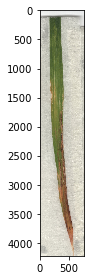

In [4]:
io.imshow(color.hsv2rgb(hsv_image) )
io.show()

## Finding the leaf

To find the pixels of the leaf, we can use the Griffiths HSV threshold method encapsulated in the function `redpatch.griffin_leaf_region()`. We pass `hsv_image` to run it with default values. The values can be changed, as we'll see later. This function returns a mask - an array of the same dimensions as the image that contains True/False values that state whether a pixel is in the image.

We can print it directly, or look at as an image using `redpatch.preview_mask()`. White pixels are those `True` ones that `redpatch.griffin_leaf_regions()` believes belong in the leaf


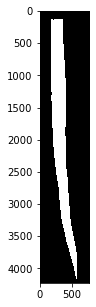

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
leaf_area_mask = rp.griffin_leaf_regions(hsv_image)
rp.preview_mask(leaf_area_mask)
leaf_area_mask

## Finding objects in a mask

The next step is to see how many objects are in this mask. This is conceptualised as regions of `True`s in the mask that are disconnected from other `True`, islands of `True`s in effect. 

We first label each island, converting all the `True`s in the first island to the digit `1`, all the `Trues` in the second island to `2` and so on. This is done with the `redpatch.label_image()` function. It returns a new mask where islands have numeric labels and the background has zeroes, and a count of the objects found.



In [6]:
labelled_leaf_area, leaf_areas_found = rp.label_image(leaf_area_mask)

We can preview the objects using the `redpatch.preview_object_labels()` function, which takes a label mask and a background image, here we'll use the `leaf_area_mask` we created above.

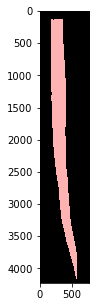

In [7]:
rp.preview_object_labels(labelled_leaf_area, leaf_area_mask)

Looks good! Looks like we found one big leaf object. Let's check that by cross referencing with the number of objects reported... 

In [8]:
leaf_areas_found

27

Not good. We actually found 27 objects. The huge main one and lots of ones that are so small they don't render in the preview. This is a consequence of having such a straightforward object call. We can get rid of the small ones by calculating the objects sizes and filtering.

### Removing noise in the background

We can get the properties of objects with the `redpatch.get_object_properties()` on the labelled image. This returns a list of `RegionProps` code objects that describe many features of the objects.   

In [9]:
leaf_area_properties = rp.get_object_properties(labelled_leaf_area)

We can then work out which of those to keep. We can filter a list of RegionProps using the `redpatch.filter_region_property()` function and a filter function. The second argument `redpatch.is_not_small` filters out all objects smaller than 50 by 50 pixels. 

After this we have one RegionProp left

In [10]:
leaf_areas_to_keep = rp.filter_region_property_list(leaf_area_properties, rp.is_not_small)
len(leaf_areas_to_keep)

1

Hopefully it's the leaf area. We  remove the labels from the label mask `labelled_leaf_area` that don't appear in our list of RegionProps to keep with `redpatch.clean_labelled_mask()`. 

We can preview the result with `redpatch.preview_object_labels()`. 

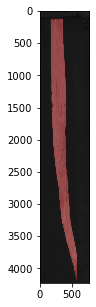

In [11]:
cleaned_leaf_area = rp.clean_labelled_mask(labelled_leaf_area, leaf_areas_to_keep)
rp.preview_object_labels(cleaned_leaf_area, hsv_image)


Great! Looks like we got the leaf on its own with no other objects.

## Extracting the leaf from the background

Once we have a leaf mask we can use it to extract the pixels matching it from the background. A slight problem is that our `cleaned_leaf_area` isn't a `True/False` mask (or its numeric equivalent a `1/0` mask), its a zero and any other integer mask - because the labelling process converted all the `1`s in islands to other numbers. We can use this idiom to set the pixels with non-zero values back to 1.

In [12]:
cleaned_leaf_area[cleaned_leaf_area > 0 ] = 1

And now we can use the `redpatch.clear_background()` function to creat a new `cleared_image` that contains only leaf pixels.

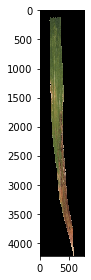

In [13]:
cleared_image = rp.clear_background(hsv_image, cleaned_leaf_area)
io.imshow(color.hsv2rgb(cleared_image))
io.show()

## Finding the healthy regions in the leaf

With a cleaned leaf image we can extract the healthy regions using Griffin's HSV method for the healthy regions, again we have the function `redpatch.griffin_healthy_regions()` for this, with default HSV settings. This function returns a mask of the healthy pixels and the `volume`, basically the number of those pixels. 

We can preview the region found.

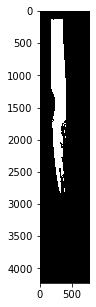

In [14]:
healthy_mask, healthy_volume = rp.griffin_healthy_regions(cleared_image)
rp.preview_mask(healthy_mask)

An assumption here is that we only really care about the total amount of healthy tissue, and not how many areas of it there are and how big the healthy areas are. If we did care about such things we would need to treat the region slightly differently, more like the lesion areas.

## Finding the lesion regions

We can find lesion regions in a similar way, here we use the `redpatch.griffin_lesion_regions()` function to find the lesion areas with some custom `h`,`s` and `v` values.

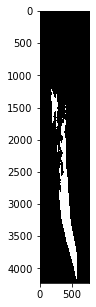

In [15]:
lesion_region_mask, lesion_region_volume = rp.griffin_lesion_regions(cleared_image, h =(0/255, 41/255), s = (38/255, 255/255), v = (111/255, 255/255))
rp.preview_mask(lesion_region_mask)

With that mask, we can go through the island labelling and object counting as before

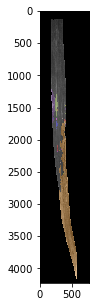

In [16]:
labelled_lesion_regions, lesion_region_count = rp.label_image(lesion_region_mask)
rp.preview_object_labels(labelled_lesion_regions, color.hsv2rgb(cleared_image))

In [17]:
lesion_region_count

473

### Filtering lesion regions

Looks like we found an awful lot of lesion regions. We can filter these as before by generating the object property list and checking that 

In [18]:
lesion_regions_properties_list = rp.get_object_properties(labelled_lesion_regions)

In [20]:
lesion_regions_to_keep = rp.filter_region_property_list(lesion_regions_properties_list, rp.is_not_small)

In [21]:
len(lesion_regions_to_keep)

3

Great, that left us with a sane three lesion region objects. Now We can clean up the object list and the label mask, and preview to make sure we got the right objects

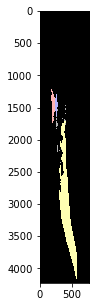

In [22]:
cleaned_labelled_lesion_regions = rp.clean_labelled_mask(labelled_lesion_regions, lesion_regions_to_keep)
rp.preview_object_labels(cleaned_labelled_lesion_regions, lesion_region_mask)

## Reporting lesion region information

The `lesion_regions_to_keep` list is made up of RegionProps objects for each lesion. 

In [23]:
lesion_regions_to_keep

We can use these object to report on the lesion size and other properties

In [25]:
first_lesion_region = lesion_regions_to_keep[0]

first_lesion_region.area

18744

In [26]:
first_lesion_region.major_axis_length

532.0879255100047

## Counting lesion centres in lesion regions

Now that we have lesion regions we can start to find the dark central spots that indicate the lesion centre. We will need the cleaned subimage around of our lesion region and then we can threshold within that. As a lesion region (`RegionProps`) object knows which part of the source image it comes from we can use the `redpatch.get_region_subimage()` function to pull out the subimage. We'll work on the largest lesion region. We can work which that is by looping over the `lesion_regions_to_keep` array, and printing out the size.

In [27]:
for lr in lesion_regions_to_keep:
    print(lr.area)

18744
9437
230263


It's the third one (index 2, as these things are counted from 0). We'll use that region object and extract from the background cleared image.

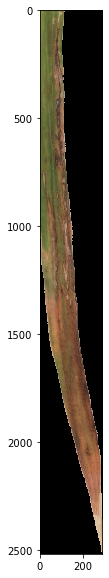

In [28]:
lesion_region_of_interest = lesion_regions_to_keep[2]

subimage = rp.get_region_subimage(lesion_region_of_interest, cleared_image)

rp.preview_hsv(subimage, height = 10)

Now we want to find some thresholds that isolate the dark spots. We can get those values by invoking an HSV slider with the subimage

In [29]:
rp.run_threshold_preview(subimage, height = 10)

interactive(children=(FloatRangeSlider(value=(0.25, 0.75), description='h', layout=Layout(width='500px'), max=…